### The battle of Chicago neighborhood for a well located Cafe

<p> The aim of this project is to help stakeholders in finding the optimal location for opening a new cafe by giving them a nice overview of Chicago's neighborhoods and their relevant characteristics. This notebook collects and combines several data sources about Chicago (e.g. neighborhoods, venues and neighborhoods) and visualizes these on a geographical map of Chicago. </p>

#### Part 1: Data Collection and cleaning

<p> Import the required libraries</p>

In [1]:
from bs4 import BeautifulSoup #library for web scraping
import requests  # library to handle requests
import json  # library to handle JSON files
import xml
import pandas as pd #Python library data manipulation and analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  55.10 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  36.23 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  37.92 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  49.02 MB/s


<p/> The neighborhood and community area data is collected using web scraping </p>

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago"
source = requests.get(url).text
data = BeautifulSoup(source, 'lxml')

In [3]:
column_names = ['Neighborhood', 'Community area']
chicago = pd.DataFrame(columns = column_names)

# loop through to find neighborhood and community area
content = data.find('div', class_='mw-parser-output')
table = content.table.tbody
ca = 'Albany Park'
neighborhood = 'Albany Park'

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            neighborhood = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 1:
            ca = td.text.strip('\n').replace(']','')
            i = i + 1
        
    chicago = chicago.append({'Neighborhood': neighborhood,'Community area': ca},ignore_index=True)


chicago.head()

Neighborhood  Community area
0      Albany Park     Albany Park
1      Albany Park     Albany Park
2  Altgeld Gardens       Riverdale
3    Andersonville       Edgewater
4   Archer Heights  Archer Heights

<p> The latitudes and longitudes are obtained using OpenStreetMap and geopy</p>

In [4]:
! pip install geopy

Requirement not upgraded as not directly required: geopy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages


In [5]:
import geopy

In [6]:
import os

In [7]:
from geopy.geocoders import Nominatim

In [8]:
df = pd.DataFrame(columns=['Neighborhood', 'Community area', 'City','State', 'Country'])
df['Address']= chicago['Neighborhood']+','+chicago['Community area']+','+'Chicago'+','+'Illinois'+','+'USA'

In [9]:
df1= pd.DataFrame(df['Address'])
df1.head(3)

Address
0    Albany Park,Albany Park,Chicago,Illinois,USA
1    Albany Park,Albany Park,Chicago,Illinois,USA
2  Altgeld Gardens,Riverdale,Chicago,Illinois,USA

In [10]:
nom=Nominatim()

In [11]:
df1['Coordinates']=df1['Address'].apply(nom.geocode)
df1.head()

Address  \
0       Albany Park,Albany Park,Chicago,Illinois,USA   
1       Albany Park,Albany Park,Chicago,Illinois,USA   
2     Altgeld Gardens,Riverdale,Chicago,Illinois,USA   
3       Andersonville,Edgewater,Chicago,Illinois,USA   
4  Archer Heights,Archer Heights,Chicago,Illinois...   

                                         Coordinates  
0  (Albany Park, Chicago, Cook County, Illinois, ...  
1  (Albany Park, Chicago, Cook County, Illinois, ...  
2                                               None  
3  (Andersonville Park, 5233, Summerdale, Edgewat...  
4  (USA Auto & Truck, South Lawndale Avenue, Glen...

In [12]:
df1['Latitude']= df1['Coordinates'].apply(lambda x: x.latitude if x!= None else None)

In [13]:
df1['Longitude']= df1['Coordinates'].apply(lambda x: x.longitude if x!= None else None)

In [14]:
df1.drop([0], inplace=True)

In [15]:
df1.dropna(inplace=True)

<p> The final dataframe</p>

In [16]:
df1.shape
df1.head()

Address  \
1        Albany Park,Albany Park,Chicago,Illinois,USA   
3        Andersonville,Edgewater,Chicago,Illinois,USA   
4   Archer Heights,Archer Heights,Chicago,Illinois...   
6                Ashburn,Ashburn,Chicago,Illinois,USA   
10             Avondale,Avondale,Chicago,Illinois,USA   

                                          Coordinates   Latitude  Longitude  
1   (Albany Park, Chicago, Cook County, Illinois, ...  41.971937 -87.716174  
3   (Andersonville Park, 5233, Summerdale, Edgewat...  41.977139 -87.669273  
4   (USA Auto & Truck, South Lawndale Avenue, Glen...  41.807590 -87.715833  
6   (Ashburn Post Office, 3629, West 79th Street, ...  41.749352 -87.713514  
10  (The Avondale, 3634, West Belmont Avenue, Avon...  41.939323 -87.718789

In [17]:
df1.shape

(126, 4)

<p> Geocoder's Nominatim() function is used again to get coordinate information about the down town neighborhood (i.e. The Loop)</p>

In [18]:
nom=Nominatim()
n= nom.geocode('Loop, Chicago, Cook County, Illinois, 60603')
latitude=n.latitude
longitude= n.longitude
print('The coordinates of down town neighborhoods are:',n.latitude,n.longitude)

The coordinates of down town neighborhoods are: 41.8816094 -87.6294574


In [19]:
# create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[41.881609,-87.629457], zoom_start=10)
folium.Marker([41.881609,-87.629457]).add_to(map_chicago)# this marker will be added to City Centre i.e The loop.
# add markers to map
for lat, lng, ca, addr in zip(df1['Latitude'], df1['Longitude'], df1['Coordinates'], df1['Address']):
    label = '{}, {}'.format(addr, ca)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

In [41]:
#code has been removed for sharing

<p> Find the venues in the busiest neighborhood of Chicago i.e The Loop. </p>

In [21]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 500 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id=SO4LDZBFFHEWFPS3X4S1BBRTVBKOCQRLJBI0V5A5OM5VTDDX&client_secret=W5K133KXL4BO5HOZAQV5OSVZGP4GT4N5OI2UQFA55TMBKJEX&v=20180605&ll=41.8816094,-87.6294574&radius=500&limit=500'

In [22]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ca275644434b90ea0ca48b5'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4b2d28fef964a520d9cf24e3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/snacks_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1c7941735',
         'name': 'Snack Place',
         'pluralName': 'Snack Places',
         'primary': True,
         'shortName': 'Snacks'}],
       'id': '4b2d28fef964a520d9cf24e3',
       'location': {'address': '4 E Madison St',
        'cc': 'US',
        'city': 'Chicago',
        'country': 'United States',
        'crossStreet': 'South State Street',
        'distance': 162,
        'formattedAddress': ['4 E Madison St (South State Street)',
         'Chicago, IL 60602',
         'United States'],
        '

In [23]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [24]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name                categories        lat        lng
0      Garrett Popcorn Shops               Snack Place  41.882054 -87.627586
1     Potbelly Sandwich Shop            Sandwich Place  41.880267 -87.629620
2                 sweetgreen               Salad Place  41.882271 -87.629236
3          Revival Food Hall                Food Court  41.879560 -87.630550
4  Roti Modern Mediterranean  Mediterranean Restaurant  41.883287 -87.629165

In [25]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


<p> From the venues returned the dataframe is sliced to check the cafes in the area</p>

In [26]:
nearby_venues[nearby_venues['categories'].str.contains('Ca')]

name                 categories        lat        lng
10  Goddess and The Baker                       Café  41.881305 -87.626117
51        Heaven On Seven  Cajun / Creole Restaurant  41.883367 -87.626220
53   Revival Cafe-Bar RCB                       Café  41.879534 -87.630636
63         Ge Pa De Caffe                       Café  41.879630 -87.625699
70  Market Creations Cafe                  Cafeteria  41.878102 -87.631624

<p> Since, the number of cafes in this area is moderate it would be plausible to open a cafe in this area. But for more assurance, it would be better to explore other neighborhoods as well.</p>

<p>Now, let's define a function that will output the top venues in each neighborhood.</p>

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    print('This may take a few seconds.\nWait...', end="", flush=True)
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('.', end="", flush=True)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
print('Function is ready to be used')

Function is ready to be used


In [34]:
neigh_venues = getNearbyVenues(names=df1['Address'], latitudes=df1['Latitude'], longitudes=df1['Longitude'])
print('Done!')

This may take a few seconds.
Wait.................................................................................................................................Done!


<p> Let's check the size and first 5 rows of the resulting dataframe.</p>

In [36]:
print(neigh_venues.shape)
neigh_venues.head()

(2761, 7)


Neighborhood  Neighborhood Latitude  \
0  Albany Park,Albany Park,Chicago,Illinois,USA              41.971937   
1  Albany Park,Albany Park,Chicago,Illinois,USA              41.971937   
2  Albany Park,Albany Park,Chicago,Illinois,USA              41.971937   
3  Albany Park,Albany Park,Chicago,Illinois,USA              41.971937   
4  Albany Park,Albany Park,Chicago,Illinois,USA              41.971937   

   Neighborhood Longitude                       Venue  Venue Latitude  \
0              -87.716174             Chicago Produce       41.970553   
1              -87.716174  Cairo Nights Hookah Lounge       41.975776   
2              -87.716174  Popeye's Louisiana Kitchen       41.968459   
3              -87.716174                   Nighthawk       41.967974   
4              -87.716174   Peking Mandarin Resturant       41.968292   

   Venue Longitude        Venue Category  
0       -87.716327         Grocery Store  
1       -87.715547            Hookah Bar  
2       -87.713156  Fast Food Restaurant  
3       -87.713415          Cocktail Bar  
4       -87.715783    Chinese Restaurant

<p> Let's find unique venue categories returned by our query. </p>

In [37]:
print('There are {} uniques categories.'.format(len(neigh_venues['Venue Category'].unique())))

There are 293 uniques categories.


<p> Getting the count of number of cafes in each neighborhood</p>

In [40]:
neigh_cafes = pd.DataFrame(columns = ['Neighborhood','Cafés'])

for neighborhood in neigh_venues.Neighborhood:

    neighborhood_venues = neigh_venues[neigh_venues.Neighborhood == neighborhood]
    neighborhood_cafes = neighborhood_venues[(neighborhood_venues['Venue Category']=='Café') | (
        neighborhood_venues['Venue Category']=='Coffee Shop')]
    
    neigh_cafes = neigh_cafes.append({'Neighborhood':neighborhood, 'Cafés':neighborhood_cafes.shape[0]}, ignore_index=True)

  
    
neigh_cafes.head()

Neighborhood Cafés
0  Albany Park,Albany Park,Chicago,Illinois,USA     1
1  Albany Park,Albany Park,Chicago,Illinois,USA     1
2  Albany Park,Albany Park,Chicago,Illinois,USA     1
3  Albany Park,Albany Park,Chicago,Illinois,USA     1
4  Albany Park,Albany Park,Chicago,Illinois,USA     1

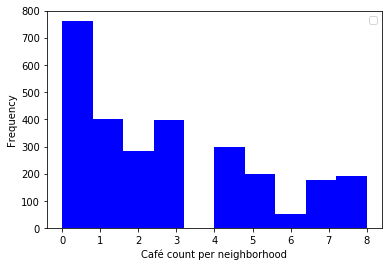

In [42]:
import matplotlib.pyplot as plt
# plot histogram
neigh_cafes.plot(kind='hist', color='blue')  

plt.xlabel('Café count per neighborhood')
plt.legend('')

# Optional: Save the histogram as a png file
# plt.savefig('Cafe_Count_Histogram.png')

plt.show()

<p> On a positive side there seem to be no cafes in a few neighborhoods. But it seems that most neighborhoods seem to have already many cafés. Let's get the names of these neighborhoods with many cafés (<=3 | >=4) and keep them in mind, it wouldn't be wise to open our new cafe in such café-rich neighborhoods.</p>

In [93]:
neigh_cafes.Neighborhood[(neigh_cafes.Cafés <= 3) | (neigh_cafes.Cafés >= 4)].tolist()

['Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Albany Park,Albany Park,Chicago,Illinois,USA',
 'Andersonville,Edgewater,Chicago,Illinois,USA',
 'Andersonville,Edgewater,Chicago,Illinois,USA',
 'Andersonville,Edgewater,Chicago,Illinois,USA',
 'Andersonville,Edgewater,Chicago,Illinois,USA',
 'Andersonville,Edgewater,Chicago,Illinois,USA',
 'Andersonville,Edgewater,Chicago,Illinois,USA',
 'Andersonville,Edge

<p> We will use the venue data to obtain the mean frequencies of the different venue categories in each neighborhood.
    We will then use this feature to group the neighborhoods into clusters.
    We will use K-means algorithm to form clusters.</p>

In [43]:
# one hot encoding
neigh_onehot = pd.get_dummies(neigh_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
neigh_onehot['Neighborhood'] = neigh_venues['Neighborhood'] 

# move district column to the first column
fixed_columns = [neigh_onehot.columns[-1]] + list(neigh_onehot.columns[:-1])
neigh_onehot = neigh_onehot[fixed_columns]

# group rows by district and by taking the mean of the frequency of occurrence of each category
neigh_grouped = neigh_onehot.groupby('Neighborhood').mean().reset_index()
print(neigh_grouped.shape)
neigh_grouped.head()

(126, 293)


Neighborhood  Yoga Studio       ATM  \
0       Albany Park,Albany Park,Chicago,Illinois,USA          0.0  0.000000   
1       Andersonville,Edgewater,Chicago,Illinois,USA          0.0  0.000000   
2  Archer Heights,Archer Heights,Chicago,Illinois...          0.0  0.000000   
3               Ashburn,Ashburn,Chicago,Illinois,USA          0.0  0.000000   
4             Avondale,Avondale,Chicago,Illinois,USA          0.0  0.032258   

   Accessories Store  Adult Boutique  African Restaurant  Airport  \
0           0.071429        0.000000                 0.0      0.0   
1           0.000000        0.012195                 0.0      0.0   
2           0.000000        0.000000                 0.0      0.0   
3           0.000000        0.000000                 0.0      0.0   
4           0.000000        0.000000                 0.0      0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0             0.000000   
1             0.0              0.0               0.0             0.012195   
2             0.0              0.0               0.0             0.000000   
3             0.0              0.0               0.0             0.000000   
4             0.0              0.0               0.0             0.000000   

   Antique Shop  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0       0.00000     0.0               0.0                0.000000   
1       0.02439     0.0               0.0                0.000000   
2       0.00000     0.0               0.0                0.000000   
3       0.00000     0.0               0.0                0.000000   
4       0.00000     0.0               0.0                0.032258   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0          0.0         0.0                  0.0          0.000000   
1          0.0         0.0                  0.0          0.012195   
2          0.0         0.0                  0.0          0.000000   
3          0.0         0.0                  0.0          0.000000   
4          0.0         0.0                  0.0          0.000000   

   Athletics & Sports  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  \
0                 0.0              0.0        0.0         0.0         0.0   
1                 0.0              0.0        0.0         0.0         0.0   
2                 0.0              0.0        0.0         0.0         0.0   
3                 0.0              0.0        0.0         0.0         0.0   
4                 0.0              0.0        0.0         0.0         0.0   

     Bakery  Bank       Bar  Baseball Field  Baseball Stadium  \
0  0.071429   0.0  0.000000             0.0               0.0   
1  0.012195   0.0  0.012195             0.0               0.0   
2  0.000000   0.0  0.111111             0.0               0.0   
3  0.000000   0.0  0.000000             0.0               0.0   
4  0.096774   0.0  0.064516             0.0               0.0   

   Basketball Court  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0               0.0    0.0              0.0   0.00000          0.0   
1               0.0    0.0              0.0   0.02439          0.0   
2               0.0    0.0              0.0   0.00000          0.0   
3               0.0    0.0              0.0   0.00000          0.0   
4               0.0    0.0              0.0   0.00000          0.0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  \
0            0.0                       0.0        0.0     0.0         0.0   
1            0.0                       0.0        0.0     0.0         0.0   
2            0.0                       0.0        0.0     0.0         0.0   
3            0.0                       0.0        0.0     0.0         0.0   
4            0.0                       0.0        0.0     0.0         0.0   

   Boat or Ferry  Bookstore  Botanical Garden  Boutique  Bowling Alley  \
0       0.000000    0.00000               0.0

<p>Printing each neighborhood along with the top 5 most common venues.</p>

In [46]:
num_top_venues = 5

for hood in neigh_grouped ['Neighborhood']:
    print("----"+hood+"----")
    temp = neigh_grouped [neigh_grouped ['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albany Park,Albany Park,Chicago,Illinois,USA----
               venue  freq
0     Sandwich Place  0.14
1  Mobile Phone Shop  0.07
2       Cocktail Bar  0.07
3  Accessories Store  0.07
4             Bakery  0.07


----Andersonville,Edgewater,Chicago,Illinois,USA----
                venue  freq
0           Pet Store  0.04
1  Italian Restaurant  0.04
2              Lounge  0.04
3         Coffee Shop  0.04
4      Sandwich Place  0.04


----Archer Heights,Archer Heights,Chicago,Illinois,USA----
                         venue  freq
0           Mexican Restaurant  0.11
1                   Restaurant  0.11
2  Eastern European Restaurant  0.11
3                          Bar  0.11
4       Transportation Service  0.11


----Ashburn,Ashburn,Chicago,Illinois,USA----
                 venue  freq
0       Clothing Store   0.2
1   Mexican Restaurant   0.2
2  Fried Chicken Joint   0.2
3   Light Rail Station   0.2
4                 Park   0.2


----Avondale,Avondale,Chicago,Illinois,USA----
         

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_ca
    tegories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Clustering

<p> Cluster Neighborhood</p>

In [82]:
# set number of clusters
kclusters = 3

neigh_grouped_clustering = neigh_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neigh_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1], dtype=int32)

<p> Examine clusters</p>

<p> cluster 1</p>

In [83]:
neigh_grouped_clustering.loc[neigh_grouped_clustering['Cluster Labels'] == 0, neigh_grouped_clustering.columns[[1] + list(range(5, neigh_grouped_clustering.shape[1]))]]

Yoga Studio  African Restaurant  Airport  Airport Lounge  \
32           0.0                 0.0      0.0             0.0   
51           0.0                 0.0      0.0             0.0   
52           0.0                 0.0      0.0             0.0   
86           0.0                 0.0      0.0             0.0   
120          0.0                 0.0      0.0             0.0   

     Airport Service  Airport Terminal  American Restaurant  Antique Shop  \
32               0.0               0.0                  0.0           0.0   
51               0.0               0.0                  0.0           0.0   
52               0.0               0.0                  0.0           0.0   
86               0.0               0.0                  0.0           0.0   
120              0.0               0.0                  0.0           0.0   

     Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
32      0.0               0.0                     0.0          0.0   
51      0.0               0.0                     0.0          0.0   
52      0.0               0.0                     0.0          0.0   
86      0.0               0.0                     0.0          0.0   
120     0.0               0.0                     0.0          0.0   

     Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
32          0.0                  0.0               0.0                 0.0   
51          0.0                  0.0               0.0                 0.0   
52          0.0                  0.0               0.0                 0.0   
86          0.0                  0.0               0.0                 0.0   
120         0.0                  0.0               0.0                 0.0   

     Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
32               0.0        0.0         0.0         0.0     0.0   0.0  0.0   
51               0.0        0.0         0.0         0.0     0.0   0.0  0.0   
52               0.0        0.0         0.0         0.0     0.0   0.0  0.0   
86               0.0        0.0         0.0         0.0     0.0   0.0  0.0   
120              0.0        0.0         0.0         0.0     0.0   0.0  0.0   

     Baseball Field  Baseball Stadium  Basketball Court  Beach  \
32              0.0               0.0               0.0    0.0   
51              0.0               0.0               0.0    0.0   
52              0.0               0.0               0.0    0.0   
86              0.0               0.0               0.0    0.0   
120             0.0               0.0               0.0    0.0   

     Bed & Breakfast  Beer Bar  Beer Garden  Big Box Store  \
32               0.0       0.0          0.0            0.0   
51               0.0       0.0          0.0            0.0   
52               0.0       0.0          0.0            0.0   
86               0.0       0.0          0.0            0.0   
120              0.0       0.0          0.0            0.0   

     Bike Rental / Bike Share  Bike Shop  Bistro  Board Shop  Boat or Ferry  \
32                        0.0        0.0     0.0         0.0            0.0   
51                        0.0        0.0     0.0         0.0            0.0   
52                        0.0        0.0     0.0         0.0            0.0   
86                        0.0        0.0     0.0         0.0            0.0   
120                       0.0        0.0     0.0         0.0            0.0   

     Bookstore  Botanical Garden  Boutique  Bowling Alley  Breakfast Spot  \
32         0.0               0.0       0.0            0.0             0.0   
51         0.0               0.0       0.0            0.0             0.0   
52         0.0               0.0       0.0            0.0             0.0   
86         0.0               0.0       0.0            0.0             0.0   
120        0.0               0.0       0.0            0.0             0.0   

     Brewery  Bubble Tea Shop  Building  Burger Joint  Burrito Place  \
32       0.0

<p>cluster 2</p>

In [84]:
neigh_grouped_clustering.loc[neigh_grouped_clustering['Cluster Labels'] == 1, neigh_grouped_clustering.columns[[1] + list(range(5, neigh_grouped_clustering.shape[1]))]]

Yoga Studio  African Restaurant   Airport  Airport Lounge  \
0       0.000000            0.000000  0.000000         0.00000   
1       0.000000            0.000000  0.000000         0.00000   
2       0.000000            0.000000  0.000000         0.00000   
4       0.000000            0.000000  0.000000         0.00000   
5       0.000000            0.000000  0.000000         0.00000   
6       0.000000            0.000000  0.000000         0.00000   
7       0.000000            0.000000  0.000000         0.00000   
8       0.000000            0.000000  0.000000         0.00000   
10      0.010000            0.000000  0.000000         0.00000   
11      0.000000            0.000000  0.000000         0.00000   
12      0.000000            0.000000  0.000000         0.00000   
13      0.000000            0.032258  0.000000         0.00000   
14      0.000000            0.000000  0.000000         0.00000   
15      0.000000            0.000000  0.000000         0.00000   
17      0.000000            0.000000  0.000000         0.00000   
18      0.000000            0.000000  0.000000         0.00000   
19      0.000000            0.000000  0.000000         0.00000   
20      0.000000            0.000000  0.000000         0.00000   
21      0.000000            0.000000  0.000000         0.00000   
22      0.000000            0.000000  0.000000         0.00000   
23      0.000000            0.000000  0.000000         0.00000   
26      0.000000            0.000000  0.000000         0.00000   
27      0.000000            0.000000  0.000000         0.00000   
28      0.000000            0.026316  0.000000         0.00000   
29      0.000000            0.000000  0.000000         0.00000   
30      0.000000            0.000000  0.000000         0.00000   
31      0.000000            0.000000  0.000000         0.00000   
33      0.000000            0.000000  0.000000         0.00000   
35      0.000000            0.000000  0.000000         0.00000   
36      0.000000            0.000000  0.000000         0.00000   
37      0.020000            0.000000  0.000000         0.00000   
38      0.000000            0.000000  0.000000         0.00000   
39      0.000000            0.000000  0.000000         0.00000   
40      0.000000            0.000000  0.000000         0.00000   
41      0.000000            0.000000  0.000000         0.00000   
42      0.000000            0.000000  0.000000         0.00000   
43      0.000000            0.000000  0.000000         0.00000   
44      0.021739            0.000000  0.000000         0.00000   
45      0.000000            0.000000  0.000000         0.00000   
46      0.000000            0.000000  0.000000         0.00000   
47      0.000000            0.000000  0.000000         0.00000   
48      0.000000            0.000000  0.000000         0.00000   
49      0.000000            0.000000  0.000000         0.00000   
50      0.000000            0.000000  0.000000         0.00000   
53      0.000000            0.000000  0.000000         0.00000   
54      0.000000            0.018182  0.000000         0.00000   
55      0.000000            0.000000  0.250000         0.00000   
56      0.000000            0.000000  0.000000         0.00000   
57      0.013889            0.000000  0.000000         0.00000   
58      0.000000            0.000000  0.000000         0.00000   
59      0.000000            0.000000  0.000000         0.00000   
61      0.000000            0.000000  0.000000         0.00000   
63      0.000000            0.000000  0.000000         0.00000   
64      0.000000            0.000000  0.000000         0.00000   
65      0.000000            0.000000  0.000000         0.00000   
66      0.000000            0.000000  0.000000         0.00000   
67      0.000000            0.000000  0.000000         0.00000   
69      0.000000            0.000000  0.000000         0.00000   
70      0.000000            0.000000  0.000000         0.00000   
71      0.000000            0.000000  0.00000

<p> cluster 3</p>

In [85]:
neigh_grouped_clustering.loc[neigh_grouped_clustering['Cluster Labels'] == 2, neigh_grouped_clustering.columns[[1] + list(range(5, neigh_grouped_clustering.shape[1]))]]

Yoga Studio  African Restaurant  Airport  Airport Lounge  \
3            0.0                 0.0      0.0             0.0   
9            0.0                 0.0      0.0             0.0   
16           0.0                 0.0      0.0             0.0   
24           0.0                 0.0      0.0             0.0   
25           0.0                 0.0      0.0             0.0   
34           0.0                 0.0      0.0             0.0   
60           0.0                 0.0      0.0             0.0   
62           0.0                 0.0      0.0             0.0   
68           0.0                 0.0      0.0             0.0   
72           0.0                 0.0      0.0             0.0   
73           0.0                 0.0      0.0             0.0   
75           0.0                 0.0      0.0             0.0   
78           0.0                 0.0      0.0             0.0   
80           0.0                 0.0      0.0             0.0   
81           0.0                 0.0      0.0             0.0   
85           0.0                 0.0      0.0             0.0   
88           0.0                 0.0      0.0             0.0   
95           0.0                 0.0      0.0             0.0   
112          0.0                 0.0      0.0             0.0   
113          0.0                 0.0      0.0             0.0   
114          0.0                 0.0      0.0             0.0   
115          0.0                 0.0      0.0             0.0   
122          0.0                 0.0      0.0             0.0   

     Airport Service  Airport Terminal  American Restaurant  Antique Shop  \
3                0.0               0.0             0.000000           0.0   
9                0.0               0.0             0.000000           0.0   
16               0.0               0.0             0.000000           0.0   
24               0.0               0.0             0.000000           0.0   
25               0.0               0.0             0.000000           0.0   
34               0.0               0.0             0.000000           0.0   
60               0.0               0.0             0.000000           0.0   
62               0.0               0.0             0.000000           0.0   
68               0.0               0.0             0.000000           0.0   
72               0.0               0.0             0.111111           0.0   
73               0.0               0.0             0.111111           0.0   
75               0.0               0.0             0.000000           0.0   
78               0.0               0.0             0.000000           0.0   
80               0.0               0.0             0.000000           0.0   
81               0.0               0.0             0.000000           0.0   
85               0.0               0.0             0.000000           0.0   
88               0.0               0.0             0.000000           0.0   
95               0.0               0.0             0.000000           0.0   
112              0.0               0.0             0.000000           0.0   
113              0.0               0.0             0.166667           0.0   
114              0.0               0.0             0.000000           0.0   
115              0.0               0.0             0.000000           0.0   
122              0.0               0.0             0.000000           0.0   

     Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
3       0.0               0.0                     0.0          0.0   
9       0.0               0.0                     0.0          0.0   
16      0.0               0.0                     0.0          0.0   
24      0.0               0.0                     0.0          0.0   
25      0.0               0.0                     0.0          0.0   
34      0.0               0.0                     0.0          0.0   
60      0.0               0.0                     0.0          0.0   
62      0.0               0.0      

In [86]:
import numpy as np
# create map
cc_map = folium.Map(location=[41.8781, -87.6298], zoom_start=10)

# set colors for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
mycolors = ['#7a7979', '#00b5eb', '#8000ff', '#363136', '#ff0000']

    
# add markers to the map containing for each neighborhood the cluster label, and number of cafés
for lat, lon in zip(neigh_venues['Venue Latitude'], neigh_venues['Venue Longitude']):
    folium.CircleMarker([lat, lon],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='blue',
    fill_opacity=0.7).add_to(cc_map)

    
# display map
cc_map

<h4> To Conclude:</h4> We have a nice overview of Chicago's neighborhoods along with their venue characteristics, number of coffee shops. This map should aid investors in finding the optimal place to open a new café. This map shows a lively neighborhood with many other Restaurant venues around, but not too many cafés.